# Multistep Prediction

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17111282281214948882
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11311375975
locality {
  bus_id: 1
}
incarnation: 6339868775629569925
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 11324388148
locality {
  bus_id: 1
}
incarnation: 4519594579225757558
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:00:05.0"
]


## Loading Data

In [4]:
import json
import requests
import pandas as pd

In [5]:
def run_query(query): # A simple function to use requests to make the API call. Returns json content from query.
    request = requests.post('https://my.es.net/graphql', json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [6]:
def query_edge(edge_id, beginTime, endTime):
    query = '''
    {
      mapTopologyEdge(id: "%s") {
            name
        traffic(beginTime: "%s", endTime: "%s")
      }
    }
    ''' % (edge_id, beginTime, endTime)
    
    return  run_query(query)

In [22]:
edge_1767 = query_edge("1896", "2018-05-20T18:22:53.253Z", "2018-05-21T19:22:53.253Z")

Exception: Query failed to run by returning code of 403. 
    {
      mapTopologyEdge(id: "1896") {
            name
        traffic(beginTime: "2018-05-20T18:22:53.253Z", endTime: "2018-05-21T19:22:53.253Z")
      }
    }
    

## Clean Data

In [6]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

In [7]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

In [8]:
#Create DataFrame
points_1767 = clean_edge_data(edge_1767)
points_1767.head()

,Time,CHIC--STAR,STAR--CHIC
0,2018-04-01 18:22:30,1.351156e+10,5.171229e+10
1,2018-04-01 18:23:00,1.150464e+10,4.579439e+10
2,2018-04-01 18:23:30,1.094079e+10,4.590426e+10
3,2018-04-01 18:24:00,1.109229e+10,4.263118e+10
4,2018-04-01 18:24:30,1.092547e+10,5.861116e+10


## Feature Extraction

In [9]:
def edge_features(df, pathway):
    #Get only one pathway (CHIC--STAR)
    single_pathway = df[['Time', pathway]]

    #Convert times to datetime objects
    times = single_pathway['Time']

    #Is date weekend?
    weekends = times.apply(lambda x: x.weekday() >= 5)*1
    single_pathway['Weekend'] = weekends

    #Add day of the week
    days = times.apply(lambda x: x.weekday())
    single_pathway['Day'] = days

    #Add hours, minutes
    hours = times.apply(lambda x: x.hour)
    minutes = times.apply(lambda x: x.minute + x.second/60.)
    single_pathway['Hour'] = hours
    single_pathway['Minute'] = minutes

    return single_pathway

In [10]:
points_1767_chicstar = edge_features(points_1767, 'CHIC--STAR')
points_1767_chicstar.head()

,Time,CHIC--STAR,Weekend,Day,Hour,Minute
0,2018-04-01 18:22:30,1.351156e+10,1,6,18,22.5
1,2018-04-01 18:23:00,1.150464e+10,1,6,18,23.0
2,2018-04-01 18:23:30,1.094079e+10,1,6,18,23.5
3,2018-04-01 18:24:00,1.109229e+10,1,6,18,24.0
4,2018-04-01 18:24:30,1.092547e+10,1,6,18,24.5


## Model

In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU, Lambda
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
import keras
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [12]:
def inverse_transform(pred, traffic_scaler):    
    return traffic_scaler.inverse_transform(pred)

In [13]:
from tsfresh.feature_extraction import feature_calculators

In [14]:
def train_test_multistep(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    """Returns training and test data from Pandas DataFrame of data

    Args:
        df (DataFrame): A Pandas DataFrame containing the data for one site to another site
                        the dataframe should contain time, features (ex. Day, Month, Weekend) 
                        and the response variable.
        pathway (str): The names of the two sites separated by a double dash (ex. "CHIC--STAR")
        split_proportion (float): Proportion (from 0 to 1) of data to be allocated to training data
        seq_len_x (int): Number of time series observations to be included per training window
        seq_len_y (int): Number of time series observations to predict
        scaler (MinMaxScaler): scaler for features
        traffic_scaler (MinMaxScaler): scaler for response variable
        print_shapes (bool): True (default) to print shapes of the training and test data
                             False to turn off printing
        
        """
    
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
        result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])
    
#     for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
#         X_seq = X[index: index + seq_len_x]
#         X_seq = np.vstack((X_seq, [np.mean(X_seq)])) #mean
#         X_seq = np.vstack((X_seq, [np.std(X_seq)**2])) #variance
#         X_seq = np.vstack((X_seq, [np.max(X_seq)])) #max
#         X_seq = np.vstack((X_seq, [np.min(X_seq)])) #min
#         X_seq = np.vstack((X_seq, [feature_calculators.skewness(pd.Series(X_seq.reshape(X_seq.shape[0])))])) #skewness
#         X_seq = np.vstack((X_seq, [feature_calculators.autocorrelation(pd.Series(X_seq.reshape(X_seq.shape[0])), 1)])) #1st order autocorr
#         result_X.append(X_seq)

#         result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Normalize
    #result_X = scaler.fit_transform(result_X)
    #result_Y = traffic_scaler.fit_transform(result_Y)

    #Train-test split
    row = int(round(split_proportion * result_X.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 10, 5, scaler, traffic_scaler)

X_train shape:  (8358, 10, 1)
Y_train shape:  (8358, 5, 1)
X_test shape:  (1249, 10, 1)
Y_test shape:  (1249, 5, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Encoder/Decoder

In [ ]:
batch_size = 24
nb_epoch = 500

model_multiple_10min = Sequential()
model_multiple_10min.add(LSTM(128, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
                              return_sequences = True))
model_multiple_10min.add(TimeDistributed(Dense(1, activation = 'relu'))) 

In [96]:
batch_size = 24
nb_epoch = 150

model_multiple_10min = Sequential()
model_multiple_10min.add(LSTM(input_dim = 1, output_dim=150, return_sequences=False))
model_multiple_10min.add(RepeatVector(20)) #seq_len_y
model_multiple_10min.add(LSTM(output_dim=150, return_sequences=True))
model_multiple_10min.add(LSTM(output_dim=150, return_sequences=True))
model_multiple_10min.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  import sys
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  


In [21]:
batch_size = 1
nb_epoch = 20

model_multiple_2halfmin = Sequential()
model_multiple_2halfmin.add(LSTM(input_dim = 1, output_dim=10, return_sequences=False))
model_multiple_2halfmin.add(Dropout(0.2))
model_multiple_2halfmin.add(RepeatVector(5)) #seq_len_y
model_multiple_2halfmin.add(LSTM(output_dim=10, return_sequences=True))
model_multiple_2halfmin.add(Dropout(0.2))
model_multiple_2halfmin.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=True)`
  


In [37]:
print("-- Building --")
model_multiple_10min.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_10min.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_split = 0.2, shuffle=True)
    model_multiple_10min.reset_states()

-- Building --


NameError: name 'model_multiple_10min' is not defined

In [22]:
print("-- Building --")
model_multiple_2halfmin.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_2halfmin.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_split = 0.2, shuffle=True)
    model_multiple_2halfmin.reset_states()

-- Building --
-- Training --
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 191s - loss: 0.0040 - val_loss: 0.0023
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 191s - loss: 0.0032 - val_loss: 0.0022
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 191s - loss: 0.0031 - val_loss: 0.0027
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 190s - loss: 0.0031 - val_loss: 0.0022
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 192s - loss: 0.0030 - val_loss: 0.0024
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 191s - loss: 0.0030 - val_loss: 0.0022
Train on 6686 samples, validate on 1672 samples
Epoch 1/1
6686/6686 [==============================] - 191s - loss: 0.

In [32]:
from keras.models import load_model

model_multiple_2halfmin.save('model_multiple_2halfmin.h5')

In [59]:
# returns a compiled model
# identical to the previous one
model_multiple_10min.load_weights('model_multiple_10min.h5')

In [17]:
# returns a compiled model
# identical to the previous one
model_multiple_2halfmin.load_weights('model_multiple_2halfmin.h5')

In [23]:
# walk-forward validation on the test data
pred_x_test = model_multiple_2halfmin.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
#pred_test = inverse_transform(pred_x_test, traffic_scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
#y_test_inv = inverse_transform(y_test, traffic_scaler)

In [37]:
model_multiple_10min.evaluate(X_test, Y_test)

7424/7443 [============================>.] - ETA: 0s

0.0017535350612740968

In [34]:
#10 epochs
model_multiple_2halfmin.evaluate(X_test, Y_test)

1056/1249 [========================>.....] - ETA: 0s

0.0026185342328424593

In [23]:
predictions = []
pred = model_multiple_2halfmin.predict(X_train[-1:].reshape(1,10,1))
for i in range(500,800):
    arr = np.array(np.vstack((X_test[i][1:], [pred[0][0]]))).reshape(1,10,1)
    #pred = model_multiple_reversed.predict(arr)
    predictions_i = []
    for j in range(5):
        pred = model_multiple_2halfmin.predict(arr)
        #if j%2 == 1:
        predictions_i.append(pred[0][0])
        arr = np.array(np.vstack((arr[0][1:], [pred[0][0]]))).reshape(1,10,1)
    predictions.append(predictions_i)
print(len(predictions[0]))

5


In [30]:
for i in range(10):
    print("Predicted: ")
    print(pred_test[i])
    print("Truth: ")
    print(y_test_inv[i])

Predicted: 
[  9.84392602e+09   1.10484859e+10   1.15668419e+10   1.19451587e+10
   1.22051062e+10   1.24103864e+10   1.25766502e+10   1.27085281e+10
   1.28106875e+10   1.28845343e+10   1.29389076e+10   1.29793024e+10
   1.30092104e+10   1.30315745e+10   1.30484449e+10   1.30614825e+10
   1.30719437e+10   1.30809068e+10   1.30886410e+10   1.30953902e+10]
Truth: 
[  9.67176947e+09   1.46341372e+10   1.73016500e+10   1.15828544e+10
   1.76499706e+10   2.00022743e+10   1.45860832e+10   1.57236625e+10
   2.22847870e+10   1.65041347e+10   9.09878638e+09   1.58456970e+10
   1.91466308e+10   1.08750124e+10   1.73884303e+10   1.25952189e+10
   1.45736784e+10   1.06151653e+10   1.28981408e+10   1.58463802e+10]
Predicted: 
[  1.11247442e+10   1.16762532e+10   1.19236168e+10   1.21050604e+10
   1.22788690e+10   1.24449219e+10   1.25929492e+10   1.27198126e+10
   1.28239309e+10   1.29049723e+10   1.29644595e+10   1.30061087e+10
   1.30349353e+10   1.30559365e+10   1.30730281e+10   1.30886083e+10


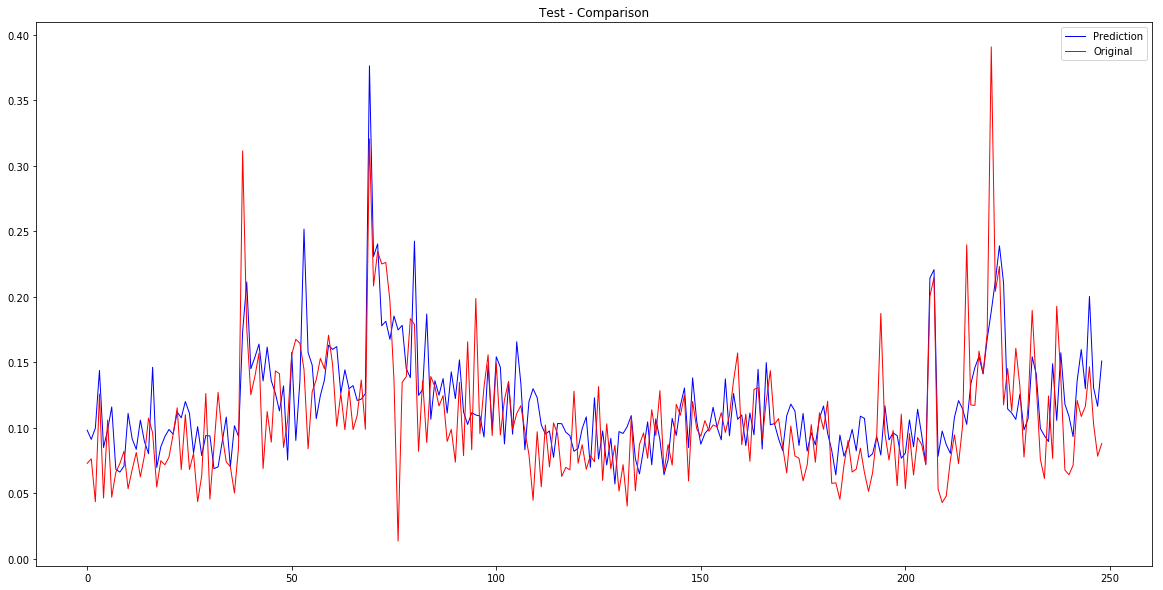

In [26]:
#1 timestep ahead has good prediction

pred_first = [item[4] for item in pred_x_test][1000:1400]
y_first = [item[4] for item in y_test][1000:1400]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

# Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import operator

In [16]:
def grid_search_data(df, pathway, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
        result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    if print_shapes:
        print("X shape: ", X.shape)
        print("Y shape: ", Y.shape)
    
    return X, Y

In [19]:
def create_model(neurons1 = 1, neurons2 = 1, dropout_rate = 0.0, optimizer = 'adam', activation = 'linear'):
    model = Sequential()
    model.add(LSTM(input_dim = 1, units = neurons1, return_sequences = False))
    model.add(Dropout(dropout_rate))
    model.add(RepeatVector(5))
    model.add(LSTM(units = neurons2, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(1, activation = activation)))
    model.compile(loss="mse", optimizer = optimizer, metrics=['accuracy'])
    return model

In [20]:
#Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

#Split data
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, "CHIC--STAR", 0.87, 10, 5, 
                                                    scaler, traffic_scaler)

X_train shape:  (8358, 10, 1)
Y_train shape:  (8358, 5, 1)
X_test shape:  (1249, 10, 1)
Y_test shape:  (1249, 5, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
if __name__ == '__main__':
    model = KerasClassifier(build_fn=create_model, verbose=0)

    batch_sizes = [5, 10, 20, 40, 60]
    epochs = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]
    optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']
    lrs = [0.001, 0.01, 0.1, 0.2, 0.3]
    momentums = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    activations = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    neurons1 = [1, 4, 5, 7, 8, 10, 15, 20, 25, 30, 64, 128]
    neurons2 = [1, 4, 5, 7, 8, 10, 15, 20, 25, 30, 64, 128]

    param_grid = dict(batch_size=batch_sizes, 
                      epochs=epochs, 
                      #optimizer=optimizer, 
                      #lr=lr, 
                      #momentum=momentum, 
                      #activation=activation, 
                      dropout_rate=dropout_rates, 
                      neurons1=neurons1,
                      neurons2=neurons2)

    #grid = GridSearchCV(estimator=model, param_grid=param_grid)
    #grid_result = grid.fit(X, Y)
    
    scores = {}
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            for epoch in epochs:
                for dropout_rate in dropout_rates:
                    for n1 in neurons1:
                        for n2 in neurons2:

                            #create model
                            model = create_model(n1, n2, dropout_rate, optimizer)

                            #train
                            for i in range(epoch):
                                model.fit(X_train, Y_train, epochs=1, batch_size=batch_size, verbose = 0,
                                                            validation_data = (X_test, Y_test), shuffle=True)
                                model.reset_states()

                            #summarize results
                            params = "Batch size: %d, Epochs: %d, Optimizer: %s, Dropout rate: %f, Neurons 1: %d, Neurons 2: %d" % (batch_size, epoch, optimizer, dropout_rate, n1, n2)
                            score, acc = model.evaluate(X_test, Y_test, verbose = 0)
                            print(params)
                            print("Score: %f, Accuracy: %f" % (score, acc))
                            scores[params] = score
                        
    best_params = min(scores.iteritems(), key=operator.itemgetter(1))[0]
    print("Best params", best_params)

#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 1
Score: 0.002594, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 4
Score: 0.002542, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 5
Score: 0.002634, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 7
Score: 0.002538, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 8
Score: 0.002570, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 10
Score: 0.002531, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 15
Score: 0.002812, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 20
Score: 0.002649, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 25
Score: 0.002592, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 30
Score: 0.002610, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 64
Score: 0.002500, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=1, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 1, Neurons 2: 128
Score: 0.002517, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 1
Score: 0.002554, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 4
Score: 0.002600, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 5
Score: 0.002567, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 7
Score: 0.002677, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 8
Score: 0.002556, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 10
Score: 0.002503, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 15
Score: 0.002544, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 20
Score: 0.002637, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 25
Score: 0.002570, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 30
Score: 0.002583, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 64
Score: 0.002537, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=4, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 4, Neurons 2: 128
Score: 0.002592, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 1
Score: 0.002788, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 4
Score: 0.002680, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 5
Score: 0.002692, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 7
Score: 0.002528, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 8
Score: 0.002581, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 10
Score: 0.002536, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 15
Score: 0.002547, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 20
Score: 0.002525, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 25
Score: 0.002429, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 30
Score: 0.002656, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 64
Score: 0.002623, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=5, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 5, Neurons 2: 128
Score: 0.002684, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 1
Score: 0.002477, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 4
Score: 0.002488, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 5
Score: 0.002913, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 7
Score: 0.002476, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 8
Score: 0.002589, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 10
Score: 0.002563, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 15
Score: 0.002539, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 20
Score: 0.002613, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 25
Score: 0.002572, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 30
Score: 0.002538, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 64
Score: 0.002455, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=7, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 7, Neurons 2: 128
Score: 0.002729, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 1
Score: 0.002610, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 4
Score: 0.002552, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 5
Score: 0.002553, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 7
Score: 0.002587, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 8
Score: 0.002563, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 10
Score: 0.002515, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 15
Score: 0.002889, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 20
Score: 0.002515, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 25
Score: 0.002475, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 30
Score: 0.002562, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 64
Score: 0.002579, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 8, Neurons 2: 128
Score: 0.002482, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 1
Score: 0.002632, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 4
Score: 0.002602, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 5
Score: 0.002509, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 7
Score: 0.002487, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 8
Score: 0.002517, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 10
Score: 0.002449, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 15
Score: 0.002466, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 20
Score: 0.002518, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 25
Score: 0.002538, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 30
Score: 0.002540, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 64
Score: 0.002529, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 10, Neurons 2: 128
Score: 0.002601, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 1
Score: 0.002549, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 4
Score: 0.002550, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 5
Score: 0.002553, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 7
Score: 0.002534, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 8
Score: 0.002538, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 10
Score: 0.002649, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 15
Score: 0.002432, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 20
Score: 0.002489, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 25
Score: 0.002604, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 30
Score: 0.002439, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 64
Score: 0.002469, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=15, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 15, Neurons 2: 128
Score: 0.002543, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 1
Score: 0.002728, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 4
Score: 0.002491, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 5
Score: 0.002499, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 7
Score: 0.002469, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 8
Score: 0.002934, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 10
Score: 0.002560, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 15
Score: 0.002661, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 20
Score: 0.002551, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 25
Score: 0.002959, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 30
Score: 0.002541, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 64
Score: 0.002446, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 20, Neurons 2: 128
Score: 0.002695, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 1
Score: 0.002511, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 4
Score: 0.002466, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 5
Score: 0.002443, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 7
Score: 0.002475, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 8
Score: 0.002495, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 10
Score: 0.002505, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 15
Score: 0.002449, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 20
Score: 0.002462, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


Batch size: 5, Epochs: 5, Optimizer: Adam, Dropout rate: 0.000000, Neurons 1: 25, Neurons 2: 25
Score: 0.002561, Accuracy: 0.000000


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=25, return_sequences=False, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


# Other Models

In [48]:
from keras.models import load_model

model_differened_10min.save('model_differenced_10min.h5')

###  Encoder/Decoder Differenced

In [12]:
def train_test_differenced(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    
    result_X = []
    result_Y = []

    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        X_seq = X[index + 1: index + seq_len_x + 1] - X[index: index + seq_len_x]
        result_X.append(X_seq) #adding CHIC--STAR
        Y_seq = X[index + seq_len_x + 1: index + seq_len_x + seq_len_y + 1] - X[index + seq_len_x: index + seq_len_x + seq_len_y]
        result_Y.append(Y_seq)
        

    result_X = np.array(result_X)
    result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Normalize
    result_X = scaler.fit_transform(result_X)
    result_Y = traffic_scaler.fit_transform(result_Y)

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_differenced(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 40, 20, scaler, traffic_scaler)

X_train shape:  (10128, 40, 1)
Y_train shape:  (10128, 20, 1)
X_test shape:  (1452, 40, 1)
Y_test shape:  (1452, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [14]:
batch_size = 24
nb_epoch = 500

model_differened_10min = Sequential()
model_differened_10min.add(LSTM(input_dim = 1, output_dim=128, return_sequences=False))
model_differened_10min.add(RepeatVector(20)) #seq_len_y
model_differened_10min.add(LSTM(output_dim=128, return_sequences=True))
#model_differened_10min.add(LSTM(output_dim=128, return_sequences=True))
model_differened_10min.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True)`
  import sys


In [15]:
model_differened_10min.load_weights('model_differenced_10min.h5')

In [46]:
print("-- Building --")
model_differened_10min.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_differened_10min.fit(X_train, Y_train, epochs=1, batch_size=batch_size, shuffle=False)
    model_differened_10min.reset_states()

-- Building --
-- Training --
Epoch 1/1
10128/10128 [==============================] - 39s - loss: 0.0043    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.3628e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.3018e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.2762e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.2543e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.2357e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.2190e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.2035e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.1888e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.1745e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 8.1607e-04    
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 38s - loss: 7.6918e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 7.7307e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6927e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.7015e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6709e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6723e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.7516e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6900e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6883e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6493e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6280e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 7.6268e-04    
Ep

10128/10128 [==============================] - 37s - loss: 6.5380e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4445e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4190e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4567e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.5533e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.6108e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4551e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4023e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.6313e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.4390e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.3606e-04    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 6.2601e-04    
Ep

In [17]:
# walk-forward validation on the test data
pred_x_test = model_differened_10min.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
pred_test = inverse_transform(pred_x_test, traffic_scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
y_test_inv = inverse_transform(y_test, traffic_scaler)

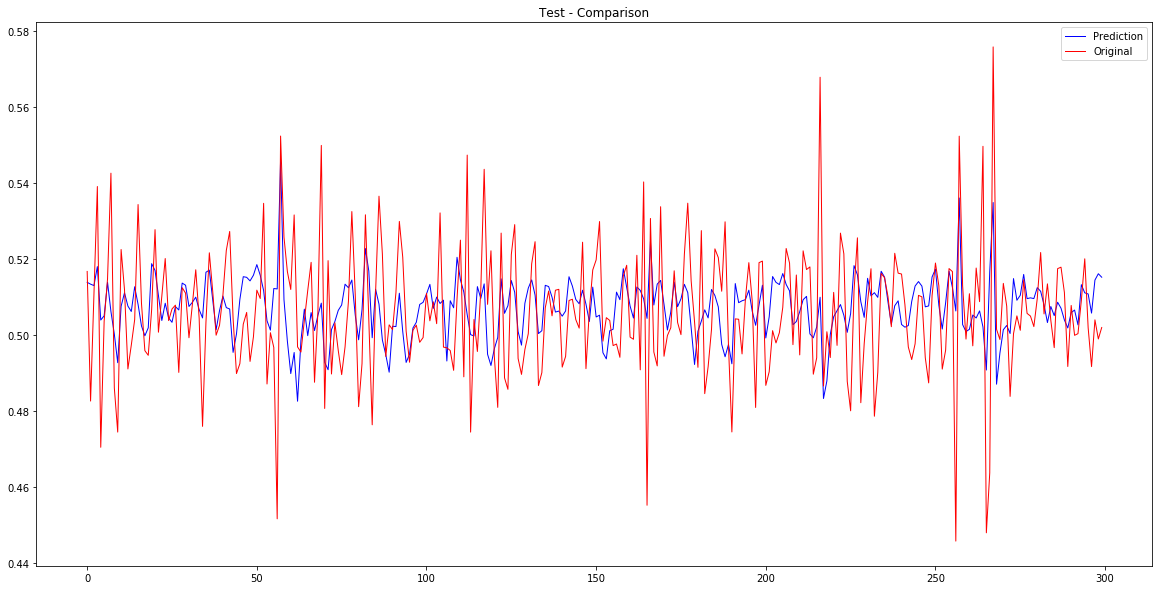

In [22]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in pred_x_test][:300]
y_first = [item[0] for item in y_test][:300]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

### Encoder/Decoder w/ features

In [46]:
def train_test_features(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = points_1767_chicstar[["CHIC--STAR"]].as_matrix()
    
    #Normalize
    #X = scaler.fit_transform(X)
    #Y = traffic_scaler.fit_transform(Y)

    result_X = []
    result_Y = []
    
    sample_count = 0
    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        #result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        X_seq = X[index: index + seq_len_x]
        mean = np.mean(X_seq)
        std = np.std(X_seq)**2
        max_val = np.max(X_seq)
        min_val = np.min(X_seq)
        skewness = feature_calculators.skewness(pd.Series(X_seq.reshape(X_seq.shape[0])))
        autocorrelation = feature_calculators.autocorrelation(pd.Series(X_seq.reshape(X_seq.shape[0])), 1)
        for val in range(index, index + seq_len_x):
            X_val = X[val]
            X_val = np.vstack((X_val, [mean])) #mean
            X_val = np.vstack((X_val, [std])) #variance
            X_val = np.vstack((X_val, [max_val])) #max
            X_val = np.vstack((X_val, [min_val])) #min
            X_val = np.vstack((X_val, [skewness])) #skewness
            X_val = np.vstack((X_val, [autocorrelation])) #1st order autocorr
            result_X.append(X_val)
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])
        sample_count += 1
        
    result_X = np.array(result_X)
    result_Y = np.array(result_Y)
    
    #Normalize
    result_X = scaler.fit_transform(np.reshape(result_X, (result_X.shape[0], result_X.shape[1])))
    result_Y = traffic_scaler.fit_transform(np.reshape(result_Y, (result_Y.shape[0], result_Y.shape[1])))
    
    #Reshape
    result_X = np.reshape(result_X, (sample_count, seq_len_x, 7))
    result_Y = np.reshape(result_Y, (sample_count, seq_len_y, 1))
    
    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    #X_train = np.reshape(X_train, (row, seq_len_x, 7))
    #X_test = np.reshape(X_test, (X_test.shape[0], seq_len_x, 7))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    #Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    #Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [68]:
def train_test_dates(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = df.drop('Time', axis = 1).as_matrix() #drop time to get all features
    Y = df[[pathway]].as_matrix()
    
    #Normalize
    X = scaler.fit_transform(X)
    Y = traffic_scaler.fit_transform(Y)

    result_X = []
    result_Y = []
    
    sample_count = 0
    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        #result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        X_seq = X[index: index + seq_len_x]
        for val in range(index, index + seq_len_x):
            result_X.append(X[val])
        result_Y.append(Y[index + seq_len_x: index + seq_len_x + seq_len_y])
        sample_count += 1
        
    result_X = np.array(result_X)
    result_Y = np.array(result_Y)
    
    #Normalize
    #result_X = scaler.fit_transform(np.reshape(result_X, (result_X.shape[0], result_X.shape[1])))
    #result_Y = traffic_scaler.fit_transform(np.reshape(result_Y, (result_Y.shape[0], result_Y.shape[1])))
    
    #Reshape
    result_X = np.reshape(result_X, (sample_count, seq_len_x, X.shape[1]))
    result_Y = np.reshape(result_Y, (sample_count, seq_len_y, 1))
    
    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    #X_train = np.reshape(X_train, (row, seq_len_x, 7))
    #X_test = np.reshape(X_test, (X_test.shape[0], seq_len_x, 7))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    #Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    #Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [69]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_dates(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 40, 20, scaler, traffic_scaler)

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


X_train shape:  (10128, 40, 5)
Y_train shape:  (10128, 20, 1)
X_test shape:  (1452, 40, 5)
Y_test shape:  (1452, 20, 1)


In [67]:
batch_size = 24
nb_epoch = 500

model_multiple_features = Sequential()
model_multiple_features.add(LSTM(input_dim = 5, output_dim=128, return_sequences=False))
model_multiple_features.add(RepeatVector(20)) #seq_len_y
model_multiple_features.add(LSTM(output_dim=128, return_sequences=True))
model_multiple_features.add(LSTM(output_dim=128, return_sequences=True))
model_multiple_features.add(TimeDistributed(Dense(1))) 
    
print("-- Building --")
model_multiple_features.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_features.fit(X_train, Y_train, epochs=1, batch_size=batch_size, shuffle=False)
    model_multiple_features.reset_states()

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=False, input_shape=(None, 4))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True)`
  import sys
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True)`
  


-- Building --
-- Training --
Epoch 1/1
 5568/10128 [===============>..............] - ETA: 23s - loss: 0.0122

KeyboardInterrupt: 

### Encoder/Decoder w/ Attention

In [16]:
import seq2seq
from seq2seq.models import SimpleSeq2Seq
from seq2seq.models import Seq2Seq
from seq2seq.models import AttentionSeq2Seq

In [21]:
batch_size = 16
nb_epoch = 100

#input sequence must be same length as output sequence in the attention scheme
seq_len_x = 10
seq_len_y = 5

scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, "CHIC--STAR", 0.9, seq_len_x, 
                                                        seq_len_y, scaler, traffic_scaler)

# define model
model_attention = AttentionSeq2Seq(input_dim=1, input_length=10, hidden_dim=10, output_length=5, output_dim=1, depth=1)


print("-- Building --")
model_attention.compile(loss='mse', 
                        optimizer='adam')

print('-- Training --')
for i in range(nb_epoch):
    model_attention.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    model_attention.reset_states()

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


X_train shape:  (51949, 10, 1)
Y_train shape:  (51949, 5, 1)
X_test shape:  (5756, 10, 1)
Y_test shape:  (5756, 5, 1)
-- Building --
-- Training --
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 110s - loss: 0.0036 - val_loss: 0.0029
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 108s - loss: 0.0025 - val_loss: 0.0027
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 109s - loss: 0.0023 - val_loss: 0.0027
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 109s - loss: 0.0022 - val_loss: 0.0027
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 108s - loss: 0.0022 - val_loss: 0.0028
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 108s - loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# walk-forward validation on the test data
pred_x_test = model_attention.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
pred_test = inverse_transform(pred_x_test, traffic_scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
y_test_inv = inverse_transform(y_test, traffic_scaler)

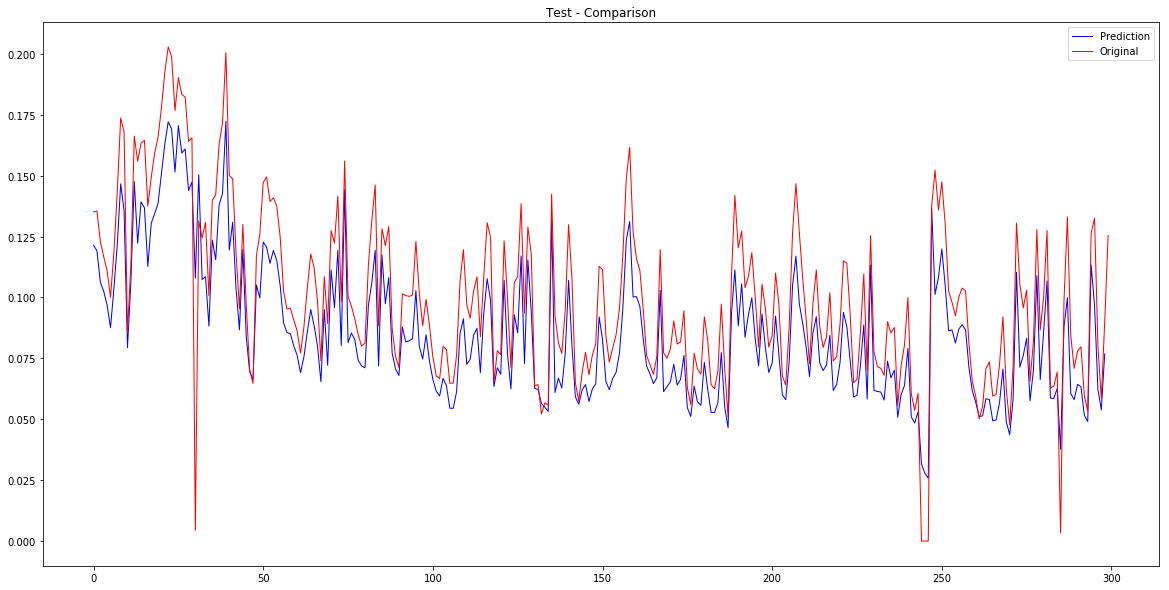

In [27]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in pred_x_test][1:300]
y_first = [item[0] for item in y_test][:300]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

### Another Encoder/Decoder (Error Buildup)

In [16]:
def train_test_diffseq2seq(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X1 = []
    result_X2 = []
    result_Y = []

    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        result_X1.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        target = X[index + seq_len_x: index + seq_len_x + seq_len_y] #target sequence
        result_Y.append(target) 
        
        result_X2.append(np.vstack((X[index + seq_len_x - 1], target[:-1]))) #mock target sequence (shifted back by 1)

    result_X1 = np.array(result_X1)
    result_X1 = result_X1.reshape(result_X1.shape[0], result_X1[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])
    
    result_X2 = np.array(result_X2)
    result_X2 = result_X2.reshape(result_X2.shape[0], result_X2[0].shape[0])

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X1_train = result_X1[:row]
    Y_train = result_Y[:row]
    X1_test = result_X1[row:]
    Y_test = result_Y[row:]
    
    X2_train = result_X2[:row]
    X2_test = result_X2[row:]
    

    X1_train = np.reshape(X1_train, (X1_train.shape[0], X1_train.shape[1], 1))
    X1_test = np.reshape(X1_test, (X1_test.shape[0], X1_test.shape[1], 1))
    
    X2_train = np.reshape(X2_train, (X2_train.shape[0], X2_train.shape[1], 1))
    X2_test = np.reshape(X2_test, (X2_test.shape[0], X2_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X1_train shape: ", X1_train.shape)
        print("X2_train shape: ", X2_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X1_test shape: ", X1_test.shape)
        print("X2_test shape: ", X2_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X1_train, X2_train, Y_train, X1_test, X2_test, Y_test

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X1_train, X2_train, Y_train, X1_test, X2_test, Y_test = train_test_diffseq2seq(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.9, 10, 5, scaler, traffic_scaler)

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


X1_train shape:  (51949, 10, 1)
X2_train shape:  (51949, 5, 1)
Y_train shape:  (51949, 5, 1)
X1_test shape:  (5756, 10, 1)
X2_test shape:  (5756, 5, 1)
Y_test shape:  (5756, 5, 1)


In [18]:
batch_size = 21
num_encoder_tokens = X1_train.shape[2]
nb_epoch = 100

# define training encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(10, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(None, 1))
decoder_lstm = LSTM(10, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1))
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
decoder_state_input_h = Input(shape=(10,))
decoder_state_input_c = Input(shape=(10,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [75]:
batch_size = 32
num_encoder_tokens = X1_train.shape[2]
nb_epoch = 500

# define training encoder
encoder_inputs = Input(shape=(20, num_encoder_tokens))
inputs = Lambda(lambda x: keras.backend.expand_dims(x, -1))(encoder_inputs)
encoder = LSTM(128)(inputs)
#encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h, state_c]

# define training decoder
#decoder_inputs = Input(shape=(None, 1))
decoded = RepeatVector(20)(encoder)
decoded = LSTM(1, return_sequences=True)(decoded)
decoded = Lambda(lambda x: keras.backend.squeeze(x, -1))(decoded)
#decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
#decoder_dense = TimeDistributed(Dense(1))
#decoder_outputs = decoder_dense(decoder_outputs)
sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoder)

# define inference encoder
#encoder_model = Model(encoder_inputs, encoder_states)

# define inference decoder
#decoder_state_input_h = Input(shape=(128,))
#decoder_state_input_c = Input(shape=(128,))
#decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
#decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
#decoder_states = [state_h, state_c]
#decoder_outputs = decoder_dense(decoder_outputs)
#decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

ValueError: Input 0 is incompatible with layer lstm_50: expected ndim=3, found ndim=4

In [41]:
print("-- Building --")
model.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model.fit([X1_train, X2_train], Y_train, 
              epochs=1, 
              batch_size=batch_size, 
              validation_split=0.2,
              shuffle=False)

-- Building --
-- Training --
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 56s - loss: 0.0017 - val_loss: 0.0015
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 54s - loss: 0.0012 - val_loss: 0.0015
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 0.0011 - val_loss: 0.0014
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 54s - loss: 0.0011 - val_loss: 0.0014
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 54s - loss: 0.0011 - val_loss: 0.0014
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 0.0011 - val_loss: 0.0014
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41559/41559 [==============================] - 55s - loss: 9.7063e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.7088e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 56s - loss: 9.7080e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
26229/41559 [=================>............] - ETA: 19s - loss: 8.8442e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41559/41559 [==============================] - 57s - loss: 9.7065e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.7004e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.7007e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.7017e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.6952e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.6907e-04 - val_loss: 0.0013
Train on 41559 samples, validate on 10390 samples
Epoch 1/1
41559/41559 [==============================] - 55s - loss: 9.6846e-04 - val_loss: 0.0013
Train on 41559 sa

Saving/Loading

In [12]:
from keras.models import load_model

In [42]:
model.save('model_encdec.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [19]:
# returns a compiled model
# identical to the previous one
model.load_weights('model_encdec.h5')
encoder_model.load_weights('encoder_model.h5')
decoder_model.load_weights('decoder_model.h5')

In [119]:
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array(source[0][source.shape[1] - cardinality:]).reshape(1, cardinality, 1)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,-1:,:])
        # update target sequence
        #target_seq = np.concatenate((source[:,1:,:], [[yhat[0,0,:]]]), axis = 1) 
        target_seq = source[:,1:,:]
        # update state
        state = infenc.predict(target_seq)
    return np.array(output)

In [127]:
predictions = []
for i in range(20,100):
    prediction = predict_sequence(encoder_model, decoder_model, X1_test[i].reshape(1, 10, 1), 5, 1)
    predictions.append(prediction)

In [128]:
pred_x_test = np.reshape(predictions, (len(predictions), len(predictions[0])))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
#y_test_inv = inverse_transform(y_test, traffic_scaler)

In [168]:
for i in range(10):
    print("Predicted: ")
    print(pred_test[i])
    print("Truth: ")
    print(y_test_inv[i])

Predicted: 
[  1.13859881e+10   1.28293704e+10   1.48374835e+10   1.68898796e+10
   1.78931978e+10   1.81812142e+10   1.82731244e+10   1.83032238e+10
   1.83131628e+10   1.83164539e+10   1.83175414e+10   1.83179018e+10
   1.83180227e+10   1.83180595e+10   1.83180718e+10   1.83180780e+10
   1.83180800e+10   1.83180800e+10   1.83180800e+10   1.83180800e+10]
Truth: 
[  1.09601279e+10   1.04230149e+10   9.80011016e+09   1.13466452e+10
   1.42833052e+10   1.23739100e+10   1.21605770e+10   1.60745160e+10
   1.03953253e+10   1.04252255e+10   1.23324522e+10   1.46597231e+10
   8.15605503e+09   9.13608943e+09   1.04815991e+10   8.85708707e+09
   9.35315194e+09   9.42771950e+09   1.17577699e+10   9.59385411e+09]
Predicted: 
[  1.21612452e+10   1.26049393e+10   1.31931402e+10   1.39868877e+10
   1.50872760e+10   1.63646116e+10   1.73479567e+10   1.79510088e+10
   1.83224402e+10   1.85163039e+10   1.86010644e+10   1.86383380e+10
   1.86547732e+10   1.86620252e+10   1.86652324e+10   1.86666455e+10


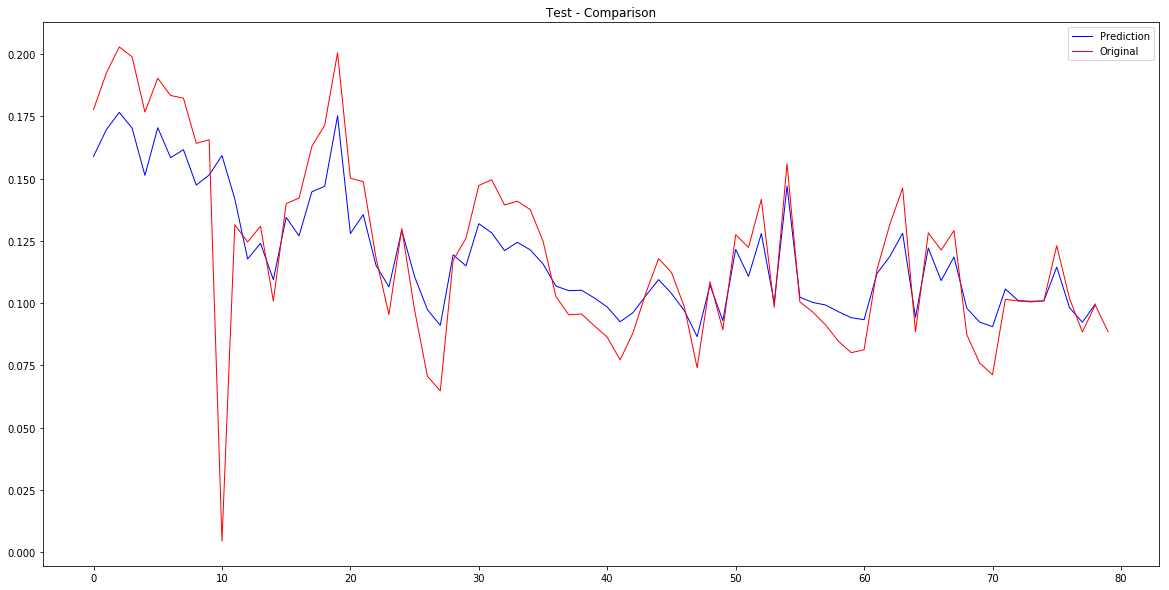

In [133]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in pred_x_test][1:]
y_first = [item[0] for item in y_test][20:100]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

## Generalization

## Amount of Training Data

In [ ]:
for i in range()

edge_1767_more = query_edge('1767', "2018-05-01T18:22:53.253Z", "2018-05-21T18:22:53.253Z")
points_1767_more = clean_edge_data(edge_1767_more)
pathway = points_1767_more.columns.values[1]
points_1767_features = edge_features(points_1767_more, pathway)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, "CHIC--STAR", 0.9, seq_len_x, 
                                                        seq_len_y, scaler, traffic_scaler)

In [ ]:
batch_size = 128
nb_epoch = 100

model_multiple_10min = Sequential()
model_multiple_10min.add(LSTM(input_dim=1, output_dim=30, return_sequences=False))
model_multiple_10min.add(RepeatVector(20)) #seq_len_y
model_multiple_10min.add(LSTM(output_dim=30, return_sequences=True))
model_multiple_10min.add(LSTM(output_dim=30, return_sequences=True))
model_multiple_10min.add(TimeDistributed(Dense(1))) 
    
print("-- Building --")
model_multiple_10min.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_10min.fit(X_train, Y_train, nb_epoch=1, batch_size=batch_size, shuffle=False)
    model_multiple_10min.reset_states()

In [ ]:
#Less data

edge_1767_less = query_edge('1767', "2018-05-18T18:22:53.253Z", "2018-05-21T18:22:53.253Z")
points_1767_less = clean_edge_data(edge_1767_less)
pathway = points_1767_less.columns.values[1]
points_1767_features = edge_features(points_1767_less, pathway)